In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!apt-get update -qq
!apt-get install -qq musescore
pip install pretty_midi

Extracting templates from packages: 100%
Selecting previously unselected package libqt5core5a:amd64.
(Reading database ... 120875 files and directories currently installed.)
Preparing to unpack .../00-libqt5core5a_5.15.3+dfsg-2ubuntu0.2_amd64.deb ...
Unpacking libqt5core5a:amd64 (5.15.3+dfsg-2ubuntu0.2) ...
Selecting previously unselected package libevdev2:amd64.
Preparing to unpack .../01-libevdev2_1.12.1+dfsg-1_amd64.deb ...
Unpacking libevdev2:amd64 (1.12.1+dfsg-1) ...
Selecting previously unselected package libmtdev1:amd64.
Preparing to unpack .../02-libmtdev1_1.1.6-1build4_amd64.deb ...
Unpacking libmtdev1:amd64 (1.1.6-1build4) ...
Selecting previously unselected package libgudev-1.0-0:amd64.
Preparing to unpack .../03-libgudev-1.0-0_1%3a237-2build1_amd64.deb ...
Unpacking libgudev-1.0-0:amd64 (1:237-2build1) ...
Selecting previously unselected package libwacom-common.
Preparing to unpack .../04-libwacom-common_2.2.0-1_all.deb ...
Unpacking libwacom-common (2.2.0-1) ...
Selecting 

In [27]:
from music21 import environment
us = environment.UserSettings()
us['musicxmlPath'] = '/usr/bin/musescore'
us['musescoreDirectPNGPath'] = '/usr/bin/musescore'


# Imports

In [91]:
import os
from music21 import converter, instrument, note, chord
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Bidirectional, Dropout, Dense,
                                     Activation, BatchNormalization, Attention,
                                     Concatenate)
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
import numpy as np
import pretty_midi
import librosa.display
import matplotlib.pyplot as plt


# Parse Midi Function

In [48]:
def parse_midi(folder_path, num_songs_to_parse=10):
    notes = []
    song_counter = 0  # Counter to keep track of the number of parsed songs

    for file in os.listdir(folder_path):
        # Ensure file has .mid or .midi extension
        if not (file.endswith(".mid") or file.endswith(".midi")):
            continue

        # If a maximum number of songs to parse is specified, and we've reached that number, exit the loop
        if num_songs_to_parse is not None and song_counter >= num_songs_to_parse:
            break

        midi = converter.parse(os.path.join(folder_path, file))
        print(f"Parsing {file}")
        notes_to_parse = midi.flatten().notes

        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))

        # Increment the song counter
        song_counter += 1
        print(f"{len(notes)} notes and chords parsed from {file}. {song_counter} songs parsed so far.")

    return notes

# Sequence Preparation Function

In [ ]:
def prepare_sequences(notes, n_vocab):
    sequence_length = 100
    pitchnames = sorted(set(item for item in notes))
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
    network_input = []
    network_output = []
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])
    n_patterns = len(network_input)
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    network_input = network_input / float(n_vocab)
    network_output = to_categorical(network_output)  # Adjusted usage
    return network_input, network_output

# LSTM Model

In [74]:
def create_model(network_input, n_vocab):
    """Create the structure of the neural network"""
    model = Sequential()
    model.add(LSTM(512, input_shape=(network_input.shape[1], network_input.shape[2]), return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(512, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(512))
    model.add(Dense(256))
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=0.001))
    return model


In [62]:
def lr_schedule(epoch, lr):
    if epoch > 100:
        return lr * 0.1
    elif epoch > 150:
        return lr * 0.01
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

In [63]:
def train_model(model, network_input, network_output, epochs=200):
    """Train the neural network"""

    # Define the learning rate scheduler
    lr_scheduler = LearningRateScheduler(lr_schedule)

    # Define ModelCheckpoint
    model_checkpoint = ModelCheckpoint(
        'best_model.h5', monitor='loss', verbose=1, save_best_only=True, mode='min'
    )

    # Train the model
    history = model.fit(
        network_input, network_output,
        epochs=epochs,
        callbacks=[lr_scheduler, model_checkpoint],
        batch_size=64,  # you might want to adjust the batch size
        validation_split=0.2  # consider using a validation split to monitor overfitting
    )

    return model, history

# Post Processing

In [75]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# Generate Notes

In [76]:
def generate_notes(model, network_input, pitchnames, n_vocab, temperature=1.0):
    """ Generate notes from the neural network based on a sequence of notes """
    # select a random sequence from the input as a starting point for the prediction
    start = np.random.randint(0, len(network_input)-1)

    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    pattern = network_input[start]
    prediction_output = []

    # generate 500 notes
    for note_index in range(500):
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)

        # Apply sampling with temperature
        index = sample(prediction[0], temperature)

        result = int_to_note[index]
        prediction_output.append(result)

        pattern = np.append(pattern, index)
        pattern = pattern[1:len(pattern)]

    return prediction_output


In [65]:
from music21 import stream

def create_midi(prediction_output, filename):
    """Convert the output from the prediction to notes and create a midi file from the notes"""
    offset = 0
    output_notes = []
    # Create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # Pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # Pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)
        # Increase offset each iteration so that notes do not stack
        offset += 0.5
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp=filename)


In [66]:
folder_path = '/content/drive/MyDrive/bach_midi'
num_songs_to_parse = 5

In [67]:
# Parse MIDI files
notes = parse_midi(folder_path, num_songs_to_parse)


Parsing beethoven_opus90_1.mid
1757 notes and chords parsed from beethoven_opus90_1.mid. 1 songs parsed so far.
Parsing beethoven_opus22_2.mid
3126 notes and chords parsed from beethoven_opus22_2.mid. 2 songs parsed so far.
Parsing beethoven_opus22_3.mid
4712 notes and chords parsed from beethoven_opus22_3.mid. 3 songs parsed so far.
Parsing beethoven_opus22_4.mid
6982 notes and chords parsed from beethoven_opus22_4.mid. 4 songs parsed so far.
Parsing beethoven_opus22_1.mid
11243 notes and chords parsed from beethoven_opus22_1.mid. 5 songs parsed so far.


In [68]:
# Prepare sequences
n_vocab = len(set(notes))
network_input, network_output = prepare_sequences(notes, n_vocab)
print(network_input, '\n', network_output)

[[[0.42325581]
  [0.37674419]
  [0.42325581]
  ...
  [0.7627907 ]
  [0.98604651]
  [0.7255814 ]]

 [[0.37674419]
  [0.42325581]
  [0.98604651]
  ...
  [0.98604651]
  [0.7255814 ]
  [0.98604651]]

 [[0.42325581]
  [0.98604651]
  [0.37674419]
  ...
  [0.7255814 ]
  [0.98604651]
  [0.90697674]]

 ...

 [[0.73488372]
  [0.73953488]
  [0.73488372]
  ...
  [0.75348837]
  [0.18604651]
  [0.66046512]]

 [[0.73953488]
  [0.73488372]
  [0.73953488]
  ...
  [0.18604651]
  [0.66046512]
  [0.4372093 ]]

 [[0.73488372]
  [0.73953488]
  [0.73488372]
  ...
  [0.66046512]
  [0.4372093 ]
  [0.19069767]]] 
 [[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [69]:
# Create the model
model = create_model(network_input, n_vocab)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 100, 512)          1052672   
                                                                 
 dropout_11 (Dropout)        (None, 100, 512)          0         
                                                                 
 lstm_12 (LSTM)              (None, 100, 512)          2099200   
                                                                 
 dropout_12 (Dropout)        (None, 100, 512)          0         
                                                                 
 lstm_13 (LSTM)              (None, 512)               2099200   
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_13 (Dropout)        (None, 256)              

# Model Training

In [70]:
# Train the model
train_model(model, network_input, network_output, epochs=10)

Epoch 1/10
139/140 [============================>.] - ETA: 0s - loss: 4.7790
Epoch 1: loss improved from inf to 4.77833, saving model to best_model.h5
140/140 [==============================] - 19s 98ms/step - loss: 4.7783 - val_loss: 4.4555 - lr: 0.0010
Epoch 2/10
139/140 [============================>.] - ETA: 0s - loss: 4.5686
Epoch 2: loss improved from 4.77833 to 4.56846, saving model to best_model.h5
140/140 [==============================] - 13s 91ms/step - loss: 4.5685 - val_loss: 4.3389 - lr: 0.0010
Epoch 3/10
139/140 [============================>.] - ETA: 0s - loss: 4.5062
Epoch 3: loss improved from 4.56846 to 4.50595, saving model to best_model.h5
140/140 [==============================] - 13s 94ms/step - loss: 4.5059 - val_loss: 4.3315 - lr: 0.0010
Epoch 4/10
139/140 [============================>.] - ETA: 0s - loss: 4.4790
Epoch 4: loss improved from 4.50595 to 4.47872, saving model to best_model.h5
140/140 [==============================] - 13s 93ms/step - loss: 4.4787 

(<keras.src.engine.sequential.Sequential at 0x7a1a626ce350>,
 <keras.src.callbacks.History at 0x7a1a6c81bdf0>)

In [77]:
# Generate notes
prediction_output = generate_notes(model, network_input, sorted(set(notes)), n_vocab)

In [78]:
# Convert generated notes to MIDI file
create_midi(prediction_output, 'sample.mid')

# Relevant Visualizations

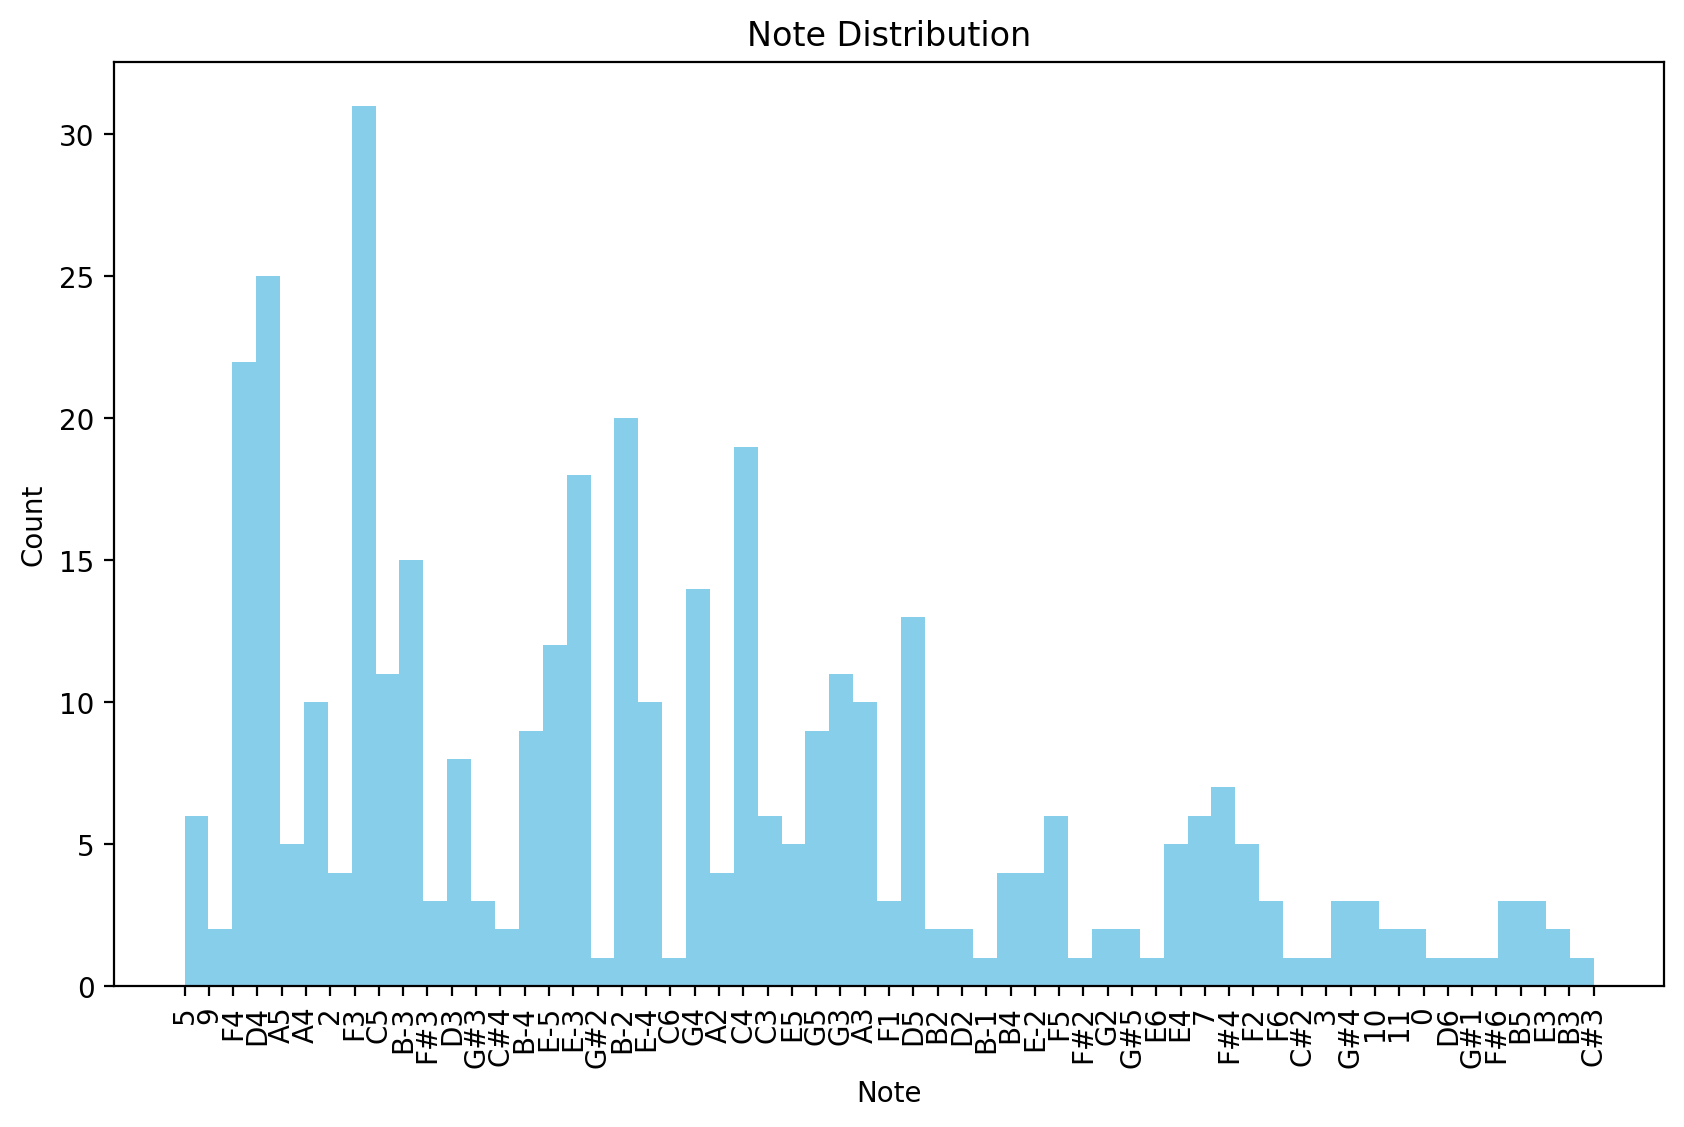

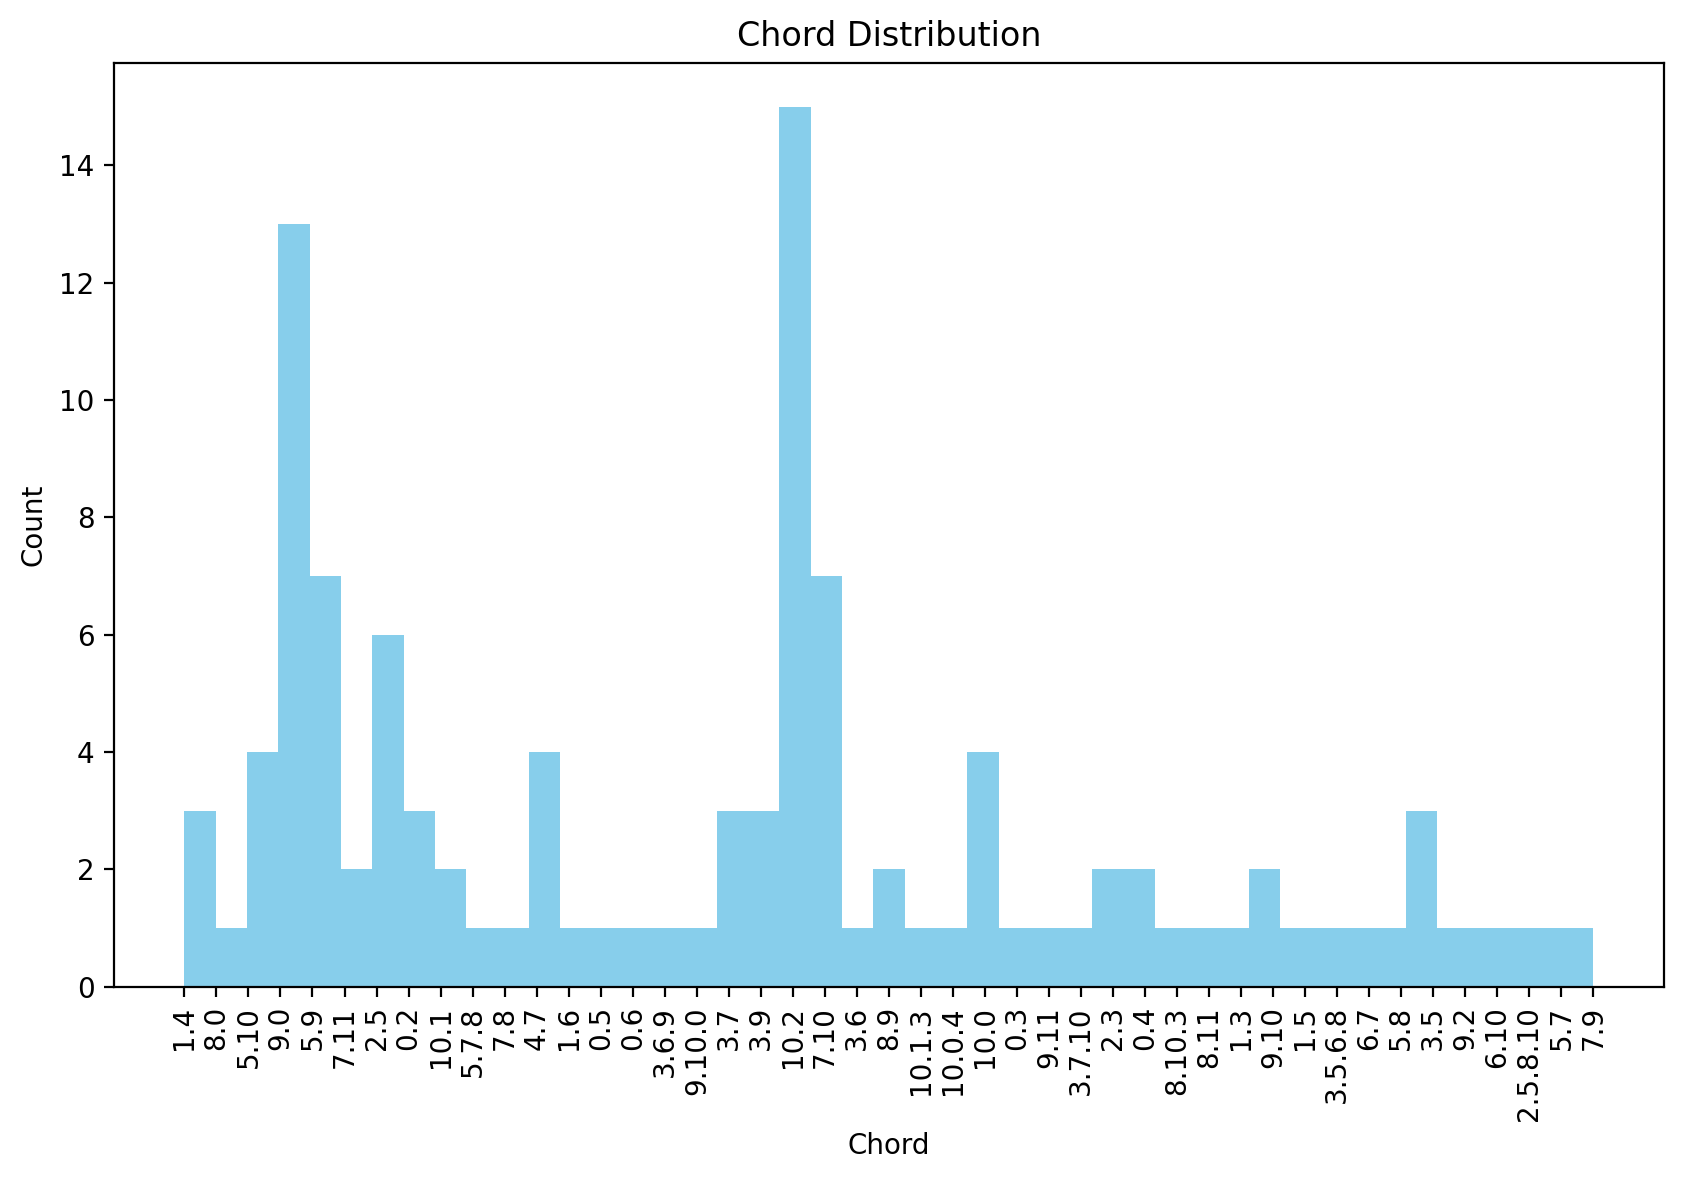

In [82]:
import matplotlib.pyplot as plt

# Extract single notes and chords separately
notes_distribution = [note for note in prediction_output if '.' not in note]  # Extracting single notes
chords_distribution = [chord for chord in prediction_output if '.' in chord]  # Extracting chords

# Plotting Note Distribution
plt.figure(figsize=(10, 6))
plt.hist(notes_distribution, bins=len(set(notes_distribution)), color='skyblue')
plt.title('Note Distribution')
plt.xlabel('Note')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

# Plotting Chord Distribution (if you'd like to visualize chord occurrences as well)
plt.figure(figsize=(10, 6))
plt.hist(chords_distribution, bins=len(set(chords_distribution)), color='skyblue')
plt.title('Chord Distribution')
plt.xlabel('Chord')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()


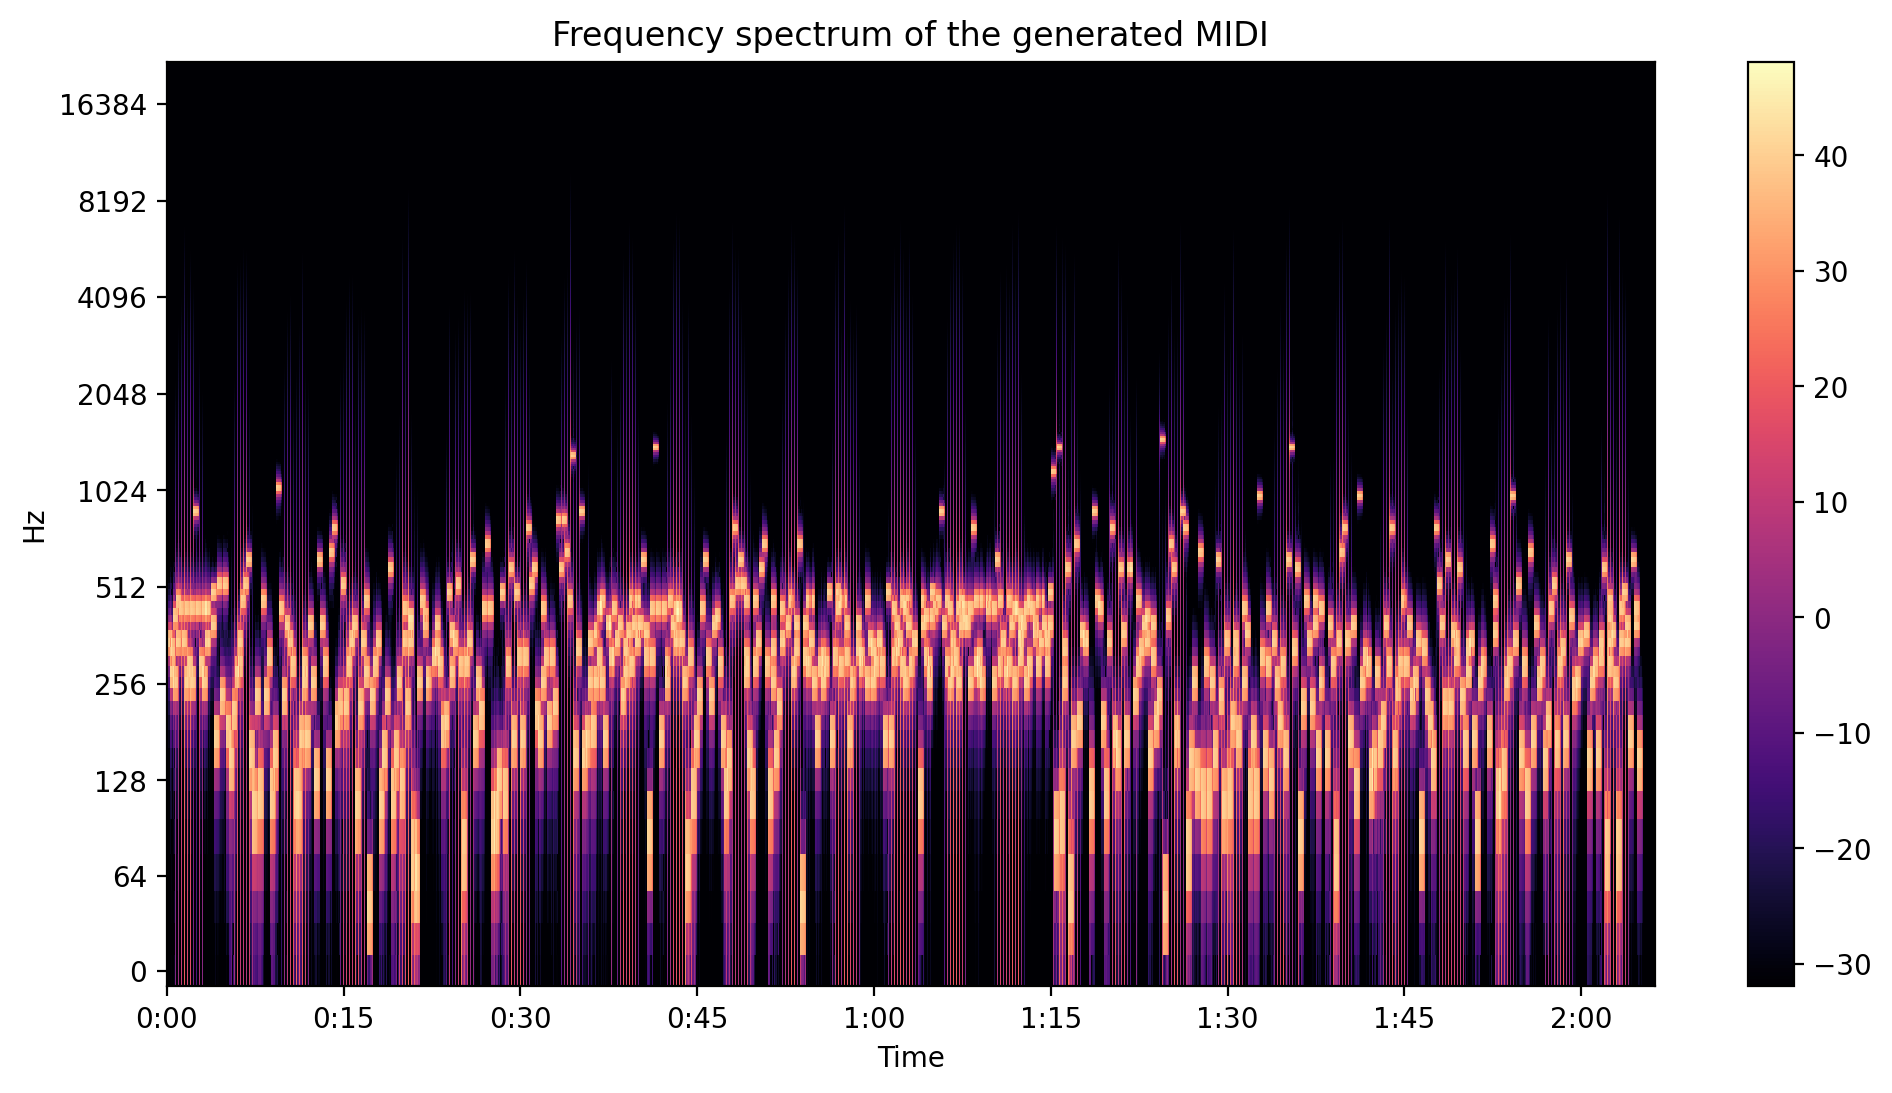

In [88]:
def midi_to_audio(midi_pretty_format):
    # Synthesize MIDI to audio
    audio_data = midi_pretty_format.synthesize()
    return audio_data

def plot_frequency_spectrum(audio_data, sr):
    # Calculate the spectrogram of the audio signal
    X = librosa.stft(audio_data)
    Xdb = librosa.amplitude_to_db(abs(X))

    # Plot the spectrogram
    plt.figure(figsize=[12,6])
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()
    plt.title('Frequency spectrum of the generated MIDI')
    plt.show()

# Convert MIDI to audio
audio_data = midi_to_audio(midi_pretty_format)

# Plot the frequency spectrum of the audio
plot_frequency_spectrum(audio_data, sr=44100)
